In [1]:
import requests
import numpy as np
import pandas as pd
from pathlib import Path
from RISparser import read, TAG_KEY_MAPPING, LIST_TYPE_TAGS

# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

## Read files from Zenodo

In [2]:
url_included = "https://zenodo.org/record/3625931/files/DOKU_All%20Included_20200116_cap.txt"
url_abstract_screening = "https://zenodo.org/record/3625931/files/DOKU_All%20FT-Screening_20200116_cap.txt"
url_all = "https://zenodo.org/record/3625931/files/DOKU_All%20TiAb-Screening_20200116_cap.txt"

In [3]:
list_keys = [TAG_KEY_MAPPING[k] for k in LIST_TYPE_TAGS]

def read_ris_to_df(url):
    """Read RIS and return pandas DataFrame"""
    
    # download data and split into lines
    r = requests.get(url)
    r.encoding = "utf-8-sig"
    lines = r.text.split("\r\n")
    
    # merge the field with multiple values
    items = []
    for item in read(lines):
        for k, v in item.items():
            if k in list_keys and item[k] is not None:
                item[k] = ";".join(item[k])
        items.append(item)

    return pd.DataFrame(items) 

In [4]:
df_all = read_ris_to_df(url_all)
df_abstract_screening = read_ris_to_df(url_abstract_screening)
df_included = read_ris_to_df(url_included)

## Clean datasets

### Step 1: Add `record_id`,  `label_included` & `label_abstarct_screening`

In [5]:
# add record_id
df_all.insert(0, "record_id", df_all.index + 1)

In [6]:
# titles of inclusions after full text screening
included_title = df_included["title"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower()
# authors of inclusions after full text screening
included_authors = df_included["authors"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower()

# titles of inclusions after abstract screening
abstract_screening_title = df_abstract_screening["title"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower()
# authors of inclusions after abstract screening
abstract_screening_authors = df_abstract_screening["authors"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower()

In [7]:
# check if included records are missing from the full dataset
df_all = df_all.assign(title_clean=df_all["title"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower())
df_all = df_all.assign(authors_clean=df_all["authors"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower())

print("Papers included, missing from full dataset:              ", (~included_title.isin(df_all["title_clean"]) & ~included_authors.isin(df_all["authors_clean"])).sum(), "\n")
print("Papers in abstract screening, missing from full dataset: ", (~abstract_screening_title.isin(df_all["title_clean"]) & ~abstract_screening_authors.isin(df_all["authors_clean"])).sum(), "\n")

Papers included, missing from full dataset:               0 

Papers in abstract screening, missing from full dataset:  0 



In [8]:
# add labels
label_included = df_all["title_clean"].isin(included_title) & df_all["authors_clean"].isin(included_authors)
label_abstract_screening = (df_all["title_clean"].isin(abstract_screening_title) & df_all["authors_clean"].isin(abstract_screening_authors)) | label_included
df_all = df_all.assign(label_included=label_included.astype(int), label_abstract_screening=label_abstract_screening.astype(int))

### Step 2: Find duplicate records and add `duplicate_id`

In [9]:
# find duplicates based on title and authors
df_all.sort_values(["label_included", "label_abstract_screening"], ascending=False, inplace=True)
duplicate = df_all.duplicated(subset=["title_clean", "authors_clean"])
df_all["duplicate_id"] = np.where(duplicate, 1, np.nan)

In [10]:
# if duplicate, duplicate_id indicates the corresponding record_id, otherwise NA
for i in range(len(df_all)):
    if df_all.loc[i, "duplicate_id"] == 1:
        df_all.loc[i, "duplicate_id"] = df_all.loc[~duplicate & df_all.loc[~duplicate, "title_clean"].isin([df_all.loc[i, "title_clean"]]) & df_all.loc[~duplicate, "authors_clean"].isin([df_all.loc[i, "authors_clean"]]), "record_id"].tolist()
df_all.duplicate_id = df_all.duplicate_id.astype("Int64")

### Step 3: Sort by orginal order and retain useful columns

In [11]:
df_all.sort_values("record_id", inplace=True)
df_all = df_all[["record_id", "title", "abstract", "keywords", "authors", "year", "doi", "label_included", "label_abstract_screening", "duplicate_id"]]

## Export datasets

In [12]:
Path("output").mkdir(parents=True, exist_ok=True)
df_all.to_csv("output/Appenzeller-Herzog_2020.csv", index=False)

## Dataset statistics

### Summary of inclusions and exclusions

In [13]:
n = len(df_all)
n_dup = (~df_all["duplicate_id"].isna()).sum()
n_wo_dup = n - n_dup
n_inc = df_all.loc[df_all.duplicate_id.isna(), "label_included"].sum()
n_inc_abs = df_all.loc[df_all.duplicate_id.isna(), "label_abstract_screening"].sum()
n_exc = n_wo_dup - n_inc
n_exc_abs = n_wo_dup - n_inc_abs
n_exc_full = n_inc_abs - n_inc

print("Total number of papers:                     ", n, "\n")
print("Total number of papers without duplicates:  ", n_wo_dup, "\n\n")
print("Total number of EXCLUSIONS:                 ", n_exc, "\n")
print("Total EXCLUSIONS after abstract screening:  ", n_exc_abs, "\n")
print("Total INCLUSIONS after abstract screening:  ", n_inc_abs, "\n")
print("Total EXCLUSIONS after full text screening: ", n_exc_full, "\n")
print("Total INCLUSIONS after full text screening: ", n_inc, " (", round(100*n_inc/n, 2), "% )\n")

Total number of papers:                      3453 

Total number of papers without duplicates:   3425 


Total number of EXCLUSIONS:                  3399 

Total EXCLUSIONS after abstract screening:   3253 

Total INCLUSIONS after abstract screening:   172 

Total EXCLUSIONS after full text screening:  146 

Total INCLUSIONS after full text screening:  26  ( 0.75 % )



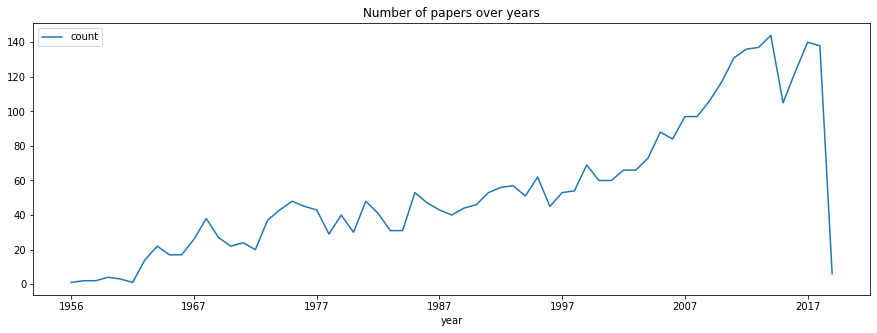

In [14]:
# number of papers over years
df_all.groupby("year").size().reset_index(name="count").set_index("year").plot(figsize=(15,5))
plt.title("Number of papers over years")
plt.show()

### Missingness of title and abstract

In [15]:
print("Number of papers with missing title:              ", df_all["title"].isna().sum(), "\n")
print("Number of papers with missing abstract:           ", df_all["abstract"].isna().sum(), "\n")
print("Number of papers with missing title AND abstract: ", (df_all["title"].isna() & df_all["abstract"].isna()).sum(), "\n")
print("Number of papers with missing title OR abstract:  ", (df_all["title"].isna() | df_all["abstract"].isna()).sum(), "\n\n")

Number of papers with missing title:               1 

Number of papers with missing abstract:            1094 

Number of papers with missing title AND abstract:  0 

Number of papers with missing title OR abstract:   1095 




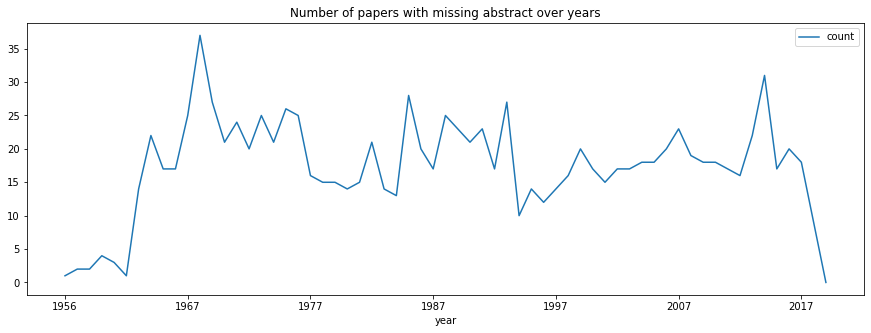

In [16]:
# missing abstract over years
df_all["abstract"].isna().groupby(df_all["year"]).sum().astype(int).\
reset_index(name="count").set_index("year").\
plot(figsize=(15,5))
plt.title("Number of papers with missing abstract over years")
plt.show()

### Word cloud for titles and abstracts

There are 275825 words in the combination of all titles. 

There are 3128802 words in the combination of all abstracts. 



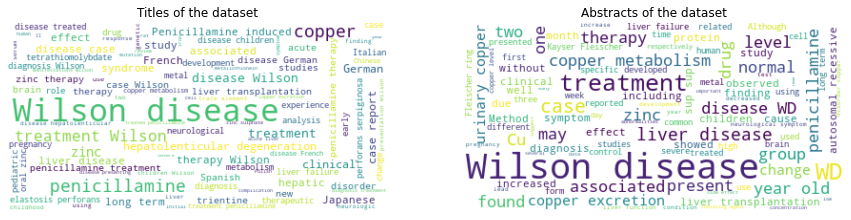

In [17]:
# create stopword list
stopwords = set(STOPWORDS)
stopwords.update(["patient", "patients", "result", "results", "conclusion", "conclusions"])

# create word cloud text
title_text = " ".join(word for word in df_all.title.dropna())
abstract_text = " ".join(word for word in df_all.abstract.dropna())
print("There are {} words in the combination of all titles.".format(len(title_text)), "\n")
print("There are {} words in the combination of all abstracts.".format(len(abstract_text)), "\n")

# generate word cloud images
title_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(title_text)
abstract_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(abstract_text)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 15])
ax1.imshow(title_wordcloud, interpolation="bilinear")
ax1.set_title("Titles of the dataset")
ax1.axis("off")
ax2.imshow(abstract_wordcloud, interpolation="bilinear")
ax2.set_title("Abstracts of the dataset")
ax2.axis("off")
plt.show()